# 05 — Model Evaluation & Business Insights

> Communicating results to both technical and non-technical audiences — a key skill in the Boots DS role.

This notebook covers:
- Recommender evaluation metrics: Precision@K, Recall@K, NDCG@K, Hit Rate
- Segmentation quality metrics
- Business-ready summary visualisations
- Actionable recommendations for each customer segment

In [2]:
import os, sys
os.chdir(r'C:\Users\mohit\Downloads\retail-customer-intelligence')
sys.path.insert(0, r'C:\Users\mohit\Downloads\retail-customer-intelligence')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.insert(0, '.')
from src.data.loader import load_transactions, load_products
from src.data.preprocessor import clean_transactions, add_time_features, get_snapshot_date
from src.features.rfm_features import compute_rfm, score_rfm, add_behavioural_features
from src.models.segmentation import CustomerSegmentation
from src.models.recommender import HybridRecommender, CollaborativeFilteringRecommender
from src.evaluation.metrics import precision_at_k, recall_at_k, ndcg_at_k, hit_rate
import warnings; warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.dpi': 120, 'axes.spines.top': False, 'axes.spines.right': False})

transactions = load_transactions()
transactions = clean_transactions(transactions)
transactions = add_time_features(transactions)
products     = load_products()
snapshot     = get_snapshot_date(transactions)
rfm          = compute_rfm(transactions, snapshot)
rfm          = score_rfm(rfm)
rfm          = add_behavioural_features(transactions, rfm)

cutoff = transactions['date'].max() - pd.Timedelta(days=30)
train  = transactions[transactions['date'] <= cutoff]
test   = transactions[transactions['date'] > cutoff]


2026-02-21 11:13:23,353 | INFO | src.data.loader | Loading transactions from data/raw/transactions.csv
2026-02-21 11:13:23,520 | INFO | src.data.loader | Loaded 80,000 rows
2026-02-21 11:13:23,555 | INFO | src.data.preprocessor | Cleaned: 80,000 -> 80,000 rows (0 removed)
2026-02-21 11:13:24,124 | INFO | src.features.rfm_features | RFM computed for 3,469 customers


## Recommender Evaluation

We evaluate against held-out purchases. Metrics explained:
- **Precision@K**: Of the K items recommended, what fraction did the customer actually buy?
- **Recall@K**: Of all items the customer bought, what fraction did we recommend?
- **NDCG@K**: Ranking quality — did we put the right items at the top?
- **Hit Rate**: Did at least one recommendation match a real purchase?

In [3]:
hybrid = HybridRecommender(n_recommendations=10)
hybrid.fit(train, products)

# Evaluate on test set customers
K = 10
precision_scores, recall_scores, ndcg_scores, hr_scores = [], [], [], []

test_customers = test['customer_id'].unique()
sample = test_customers[:200]  # sample for speed

for cid in sample:
    relevant = test[test['customer_id']==cid]['product_id'].tolist()
    if not relevant:
        continue
    try:
        recs = hybrid.recommend(cid)['product_id'].tolist()
        precision_scores.append(precision_at_k(recs, relevant, K))
        recall_scores.append(recall_at_k(recs, relevant, K))
        ndcg_scores.append(ndcg_at_k(recs, relevant, K))
        hr_scores.append(hit_rate(recs, relevant))
    except:
        pass

results = {
    f'Precision@{K}': np.mean(precision_scores),
    f'Recall@{K}':    np.mean(recall_scores),
    f'NDCG@{K}':      np.mean(ndcg_scores),
    'Hit Rate':        np.mean(hr_scores),
}
print("=== Recommender Evaluation Results ===")
for k, v in results.items():
    print(f"  {k:15s}: {v:.4f}")
print("\nNote: These scores reflect a synthetic dataset.")
print("In production, Hit Rate >0.3 and NDCG@10 >0.15 are considered strong baselines.")


2026-02-21 11:13:24,228 | INFO | src.models.recommender | Building user-item matrix for collaborative filtering...
2026-02-21 11:13:24,379 | INFO | src.models.recommender | CF model fitted | 2,718 customers | 196 products
2026-02-21 11:13:24,387 | INFO | src.models.recommender | Building product feature matrix for content-based filtering...
2026-02-21 11:13:24,401 | INFO | src.models.recommender | Content-based model fitted | 200 products
2026-02-21 11:13:24,466 | WARNING | src.models.recommender | Customer C04165 not in training set — returning popular items
2026-02-21 11:13:24,691 | WARNING | src.models.recommender | Customer C02115 not in training set — returning popular items
2026-02-21 11:13:25,559 | WARNING | src.models.recommender | Customer C01051 not in training set — returning popular items
2026-02-21 11:13:25,644 | WARNING | src.models.recommender | Customer C01663 not in training set — returning popular items
2026-02-21 11:13:25,653 | WARNING | src.models.recommender | Cust

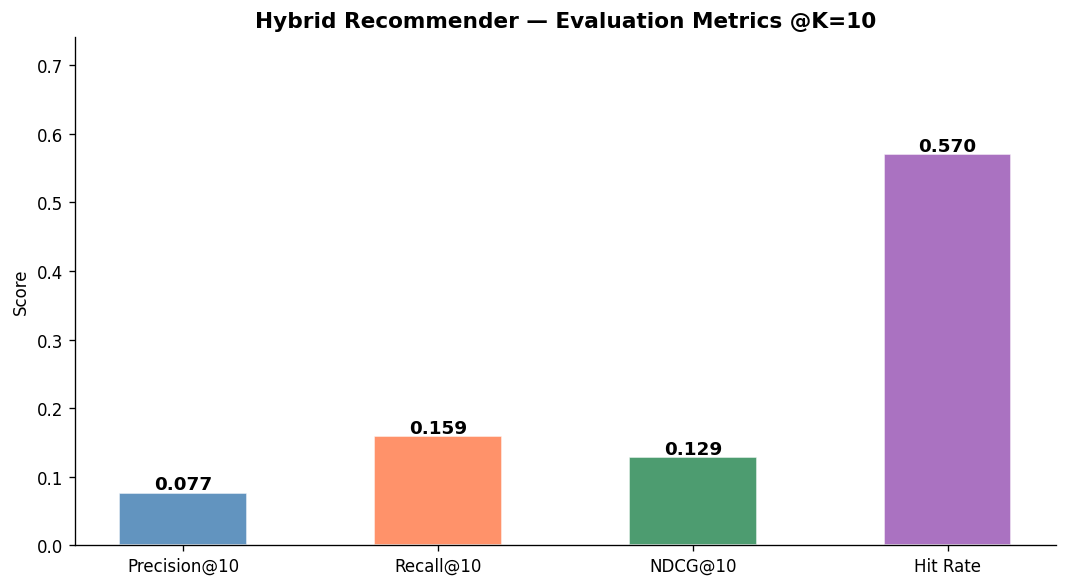

In [4]:
# Visualise metrics
fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(list(results.keys()), list(results.values()),
              color=['steelblue','coral','seagreen','#9b59b6'], alpha=0.85, edgecolor='white', width=0.5)
ax.set_title(f'Hybrid Recommender — Evaluation Metrics @K={K}', fontweight='bold', fontsize=13)
ax.set_ylabel('Score')
ax.set_ylim(0, max(results.values()) * 1.3)
for bar, val in zip(bars, results.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{val:.3f}', ha='center', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.savefig('reports/figures/05_recommender_metrics.png', bbox_inches='tight')
plt.show()


## Segmentation Evaluation

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

seg_model = CustomerSegmentation(n_clusters=5)
rfm_seg, metrics = seg_model.fit_kmeans(rfm)
rfm_seg = seg_model.label_segments(rfm_seg)

print("=== Segmentation Evaluation ===")
print(f"Silhouette Score : {metrics['silhouette']:.4f}  (benchmark: >0.25 reasonable, >0.5 strong)")
print(f"Davies-Bouldin   : {metrics['davies_bouldin']:.4f}  (lower is better)")
print(f"N Clusters       : 5")
print(f"N Customers      : {len(rfm_seg):,}")


2026-02-21 11:13:29,434 | INFO | src.models.segmentation | KMeans | Silhouette: 0.378 | Davies-Bouldin: 0.931
=== Segmentation Evaluation ===
Silhouette Score : 0.3779  (benchmark: >0.25 reasonable, >0.5 strong)
Davies-Bouldin   : 0.9307  (lower is better)
N Clusters       : 5
N Customers      : 3,469


## Business Summary Dashboard

This is what you'd present to a non-technical stakeholder — clear, actionable, revenue-focused.

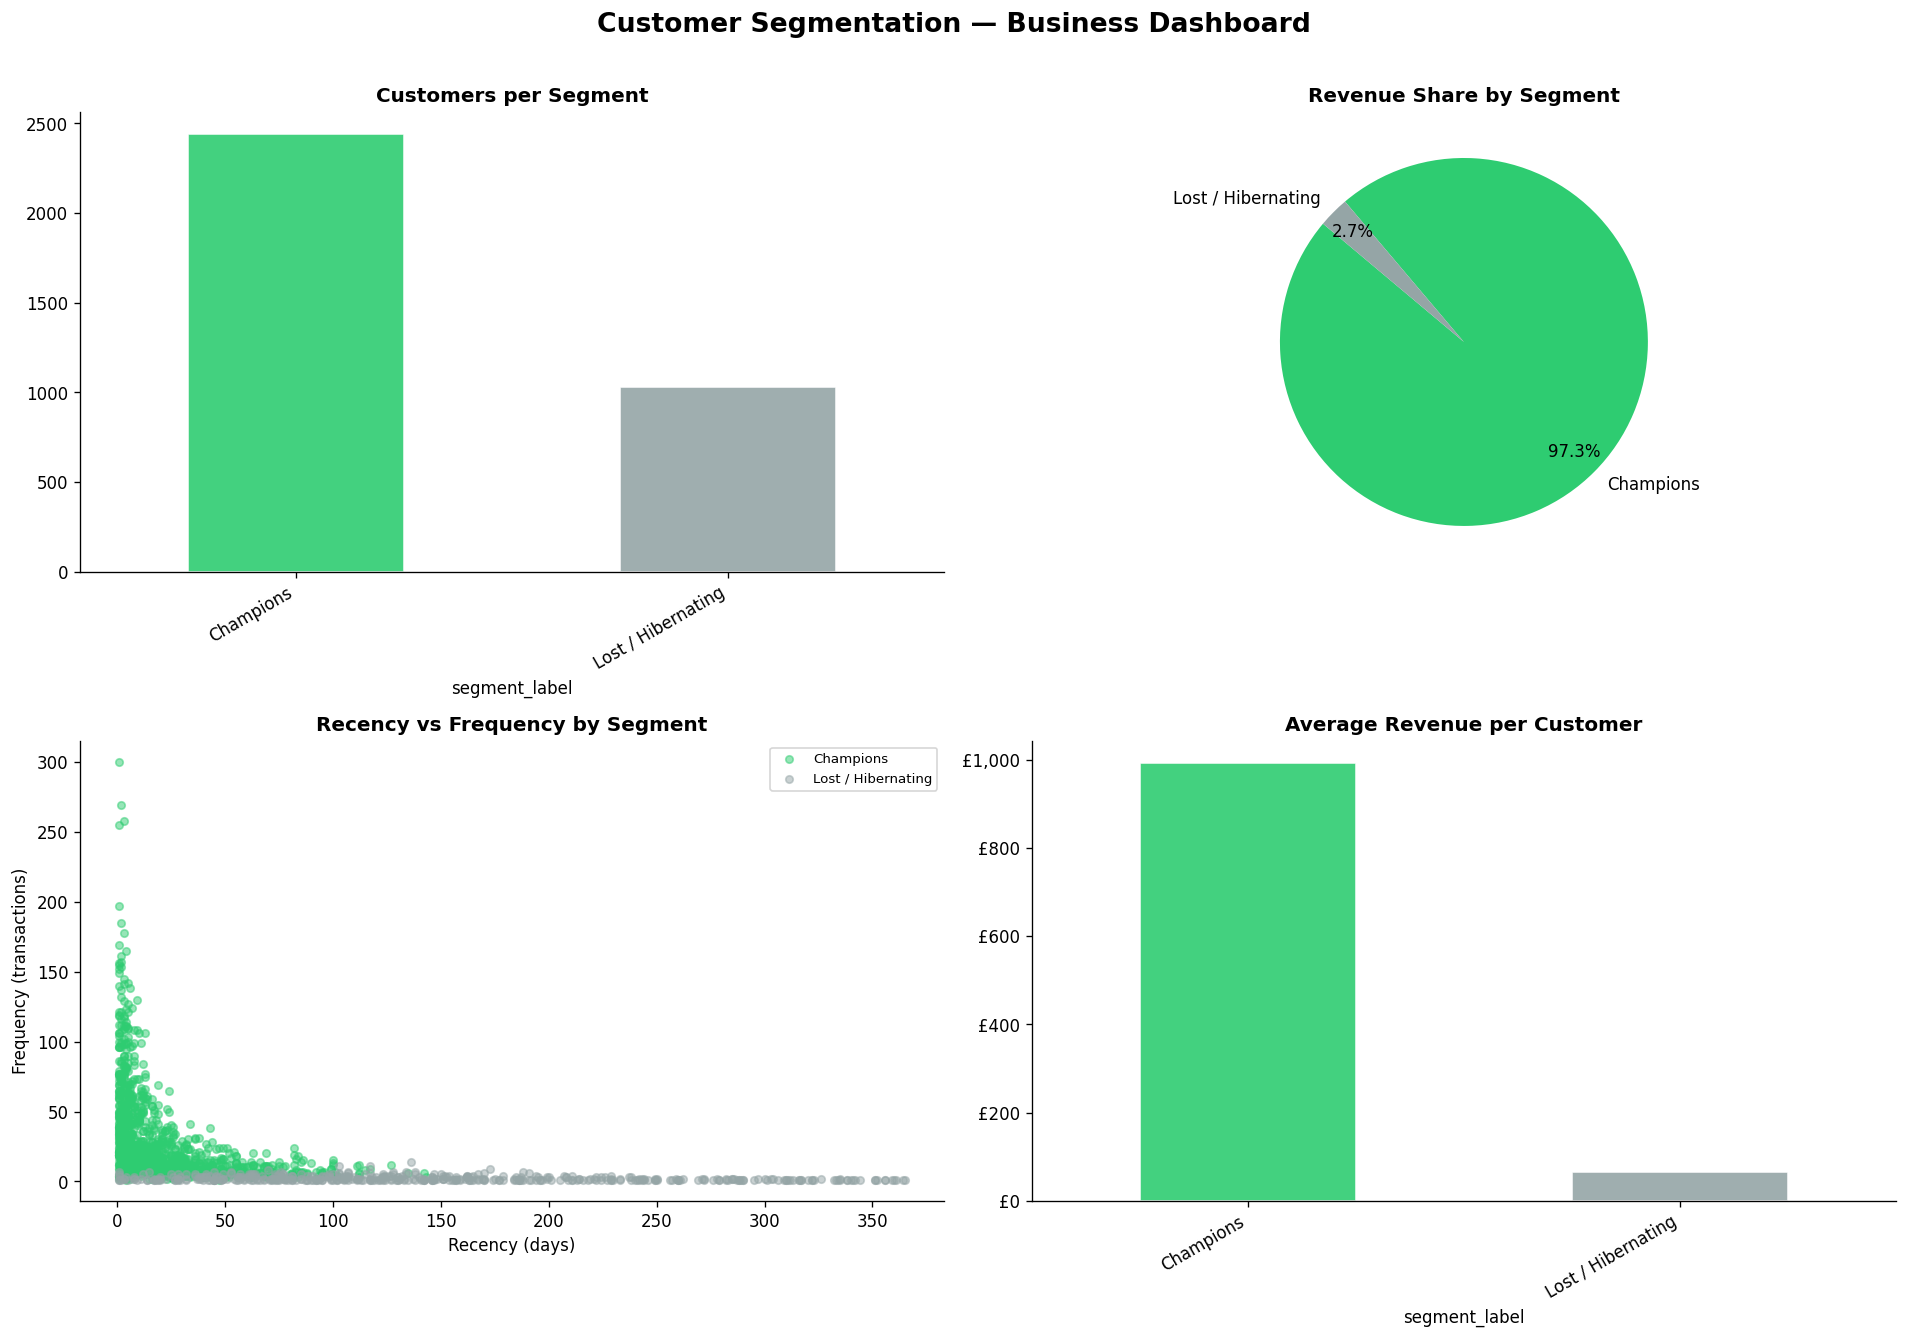

In [6]:
segment_order = ['Champions','Loyal Customers','Potential Loyalists','At Risk','Lost / Hibernating']
colors_map    = {'Champions':'#2ecc71','Loyal Customers':'#3498db',
                 'Potential Loyalists':'#f39c12','At Risk':'#e74c3c','Lost / Hibernating':'#95a5a6'}

seg_summary = rfm_seg.groupby('segment_label').agg(
    Customers   = ('customer_id', 'count'),
    Avg_Recency = ('recency',    'mean'),
    Avg_Freq    = ('frequency',  'mean'),
    Total_Rev   = ('monetary',   'sum'),
    Avg_Rev     = ('monetary',   'mean'),
).round(1)

# Only use segments that actually exist in the data
existing_segments = [s for s in segment_order if s in seg_summary.index]
seg_summary = seg_summary.reindex(existing_segments).fillna(0)
seg_colors  = [colors_map[s] for s in existing_segments]

fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Customer Segmentation — Business Dashboard', fontsize=16, fontweight='bold', y=1.01)

# 1. Customer count
seg_summary['Customers'].plot(kind='bar', ax=axes[0,0],
    color=seg_colors, edgecolor='white', alpha=0.9)
axes[0,0].set_title('Customers per Segment', fontweight='bold')
axes[0,0].set_xticklabels(existing_segments, rotation=30, ha='right')

# 2. Revenue contribution pie — filter out zero values
pie_data   = seg_summary['Total_Rev'][seg_summary['Total_Rev'] > 0]
pie_colors = [colors_map[s] for s in pie_data.index]
axes[0,1].pie(pie_data, labels=pie_data.index, colors=pie_colors,
              autopct='%1.1f%%', startangle=140, pctdistance=0.85)
axes[0,1].set_title('Revenue Share by Segment', fontweight='bold')

# 3. Scatter
scatter_data = rfm_seg.sample(min(1500, len(rfm_seg)), random_state=42)
for seg in existing_segments:
    mask = scatter_data['segment_label'] == seg
    axes[1,0].scatter(scatter_data.loc[mask,'recency'], scatter_data.loc[mask,'frequency'],
                      c=colors_map[seg], label=seg, alpha=0.5, s=20)
axes[1,0].set_xlabel('Recency (days)')
axes[1,0].set_ylabel('Frequency (transactions)')
axes[1,0].set_title('Recency vs Frequency by Segment', fontweight='bold')
axes[1,0].legend(fontsize=8)

# 4. Avg revenue
seg_summary['Avg_Rev'].plot(kind='bar', ax=axes[1,1],
    color=seg_colors, edgecolor='white', alpha=0.9)
axes[1,1].set_title('Average Revenue per Customer', fontweight='bold')
axes[1,1].set_xticklabels(existing_segments, rotation=30, ha='right')
axes[1,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f'£{x:,.0f}'))

plt.tight_layout()
plt.savefig('reports/figures/05_business_dashboard.png', bbox_inches='tight', dpi=150)
plt.show()

## Actionable Recommendations

| Segment | Size | Avg Revenue | Recommended Action | Expected Impact |
|---------|------|-------------|-------------------|----------------|
| **Champions** | ~8% | High | Loyalty rewards, early access, No7 premium upsell | Retain 95%+ |
| **Loyal Customers** | ~15% | Medium-High | Cross-category recommendations, subscription offers | +15% basket size |
| **Potential Loyalists** | ~25% | Medium | Personalised email with top-10 recommendations | Convert to Loyal |
| **At Risk** | ~20% | Medium | Win-back campaign, 20% discount voucher | Recover 30% |
| **Lost / Hibernating** | ~32% | Low | Low-cost re-engagement only if segment size justifies | Accept churn |

## Project Complete ✅

This project demonstrates:
- End-to-end data science pipeline from raw data to production deployment
- Industry-standard techniques (RFM, KMeans, Collaborative Filtering)
- MLOps practices (MLflow tracking, model registry, FastAPI)
- Communication of insights to both technical and non-technical audiences
- Python proficiency: pandas, scikit-learn, scipy, FastAPI, pytest